### 👨‍🏭 Albertus Septian Angkuw

#### Pembuatan Call Graph

In [424]:
%pip install pycg

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [425]:
# currentPath = input("")
currentPath = "/home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo16"
print('Current Path set:' ,currentPath)

Current Path set: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo16


In [426]:
import os
def walkTroughFolder(folderSC,filterExt='.py'):
    listFile = []
    for file in os.listdir(f'{currentPath}/{folderSC}'):
        if os.path.isdir(f'{currentPath}/{folderSC}/{file}'):
            listFile += walkTroughFolder(f'{folderSC}/{file}')
        elif file.endswith(filterExt):
            #print(os.path.join(f'/{folderSC}', file))
            listFile.append(os.path.join(f'/{folderSC}', file))
    return listFile

In [427]:
import time
def scanPyCG(currentPath,package):
    timestamp = int(time.time())
    targetFile = f'py_files=$(find {currentPath}/{package} -type f -name "*.py")'
    execute = f'pycg --package {package} $py_files -o {currentPath}/{package}-{timestamp}.json '
    os.system(f'{targetFile} && {execute}')
    return f'{currentPath}/{package}-{timestamp}.json'

In [428]:
print(f'Total py Files "Odoo": {len(walkTroughFolder("odoo"))} Files "Addons": {len(walkTroughFolder("addons"))} ')

Total py Files "Odoo": 412 Files "Addons": 4853 


In [429]:
# addonsJSON = scanPyCG(currentPath,f'{folderSC}/addons')
# odooJSON = scanPyCG(currentPath,f'{folderSC}/odoo')

In [430]:
addonsJSON = f'{currentPath}/odooOnlyAddonsNoPackage.json'
odooJSON = f'{currentPath}/odooCoreNoPackage.json'

#### Pembacaan Hasil Call Graph JSON

In [431]:
import json
def loadJSON(path):
   return json.load(open(path))

In [432]:
cgAddonsSource =loadJSON(addonsJSON)
cgOdooSource =loadJSON(odooJSON)
print(list(cgAddonsSource.values())[:5])
print(list(cgOdooSource.values())[:5])

[[], [], ['odoo.api.depends'], ['odoo.fields.Date.today', 'odoo.models.Model.product_id.with_company', 'odoo.models.Model.browse', '<builtin>.super'], []]
[[], [], [], ['odoo.fields.Char'], []]


In [433]:
print(len(cgOdooSource))
print(len(cgAddonsSource))

5586
24931


In [434]:
def getListRootPackage(path):
    listRootPackage = []
    for file in os.listdir(f'{path}'):
        if os.path.isdir(f'{path}/{file}'):
            listRootPackage.append(file)
        elif file.endswith('.py'):
            listRootPackage.append('.'.join(file.split(".")[:-1]))
    return listRootPackage

In [435]:
def addPrefixFolder(cg,root,listPackage):
    def checkParent(key):
        parentkey = key.split('.')[0]
        if parentkey in listPackage:
            key = f'{root}.{key}'
        return key
    newCG = {}
    for key, relation in cg.items():
        key = checkParent(key)
        if key not in newCG:
            newCG[key] = []
        for i in relation:
            newRelKey = checkParent(i)
            newCG[key].append(newRelKey)
    return newCG

In [436]:
listPackageOdoo = getListRootPackage(f'{currentPath}/odoo')
listPackageAddons = getListRootPackage(f'{currentPath}/addons')

In [437]:
cgOdoo = addPrefixFolder(cgOdooSource,"odoo",listPackageOdoo)
cgAddons = addPrefixFolder(cgAddonsSource,"addons",listPackageAddons)

In [438]:
cgSource = {}
for key, rel in cgOdoo.items():
    if key not in cgSource:
        cgSource[key] = []
    for tmp in rel:
        if tmp not in cgSource:
            cgSource[tmp] = []
    cgSource[key] = cgSource[key] + rel

for key, rel in cgAddons.items():
    if key not in cgSource:
        cgSource[key] = []
    for tmp in rel:
        if tmp not in cgSource:
            cgSource[tmp] = []
    cgSource[key] = cgSource[key] + rel

In [439]:
len(cgSource)

29821

#### Call Graph Raw

In [440]:
callGraphRaw = {}
for key, value in cgSource.items():
    callGraphRaw[key] = {}
    for v in value:
        callGraphRaw[key][v] = 1

In [441]:
# buatGraphviz(graph=callGraphRaw,filename=f'{folderSC}-RAW-CG')

#### Filter Call diluar Project

In [442]:
callGraphFiltered = {}
listRootFolder = [ 'odoo', 'addons']
edgeGraph = []
outsideCall = set()
for key, value in cgSource.items():
    rootSource = key.split('.')[0]
    if rootSource not in listRootFolder:
        outsideCall.add(rootSource)
        continue
    childFilter = {}
    for v in value:
        childSource = v.split('.')[0]
        if childSource not in listRootFolder:
            outsideCall.add(childSource)
            continue
        childFilter[v] = 1
    if len(childFilter) == 0:
        edgeGraph.append(key)
        continue
    for c in childFilter:
        if c not in callGraphFiltered:
            callGraphFiltered[c] = {}
    callGraphFiltered[key] = childFilter
    
print(f'Total Top Node: {len(callGraphFiltered)} ')
print(f'Total Edge: {len(edgeGraph)} <{edgeGraph[:3]}>')
print(f'Total OutsideEdge: {len(outsideCall)} <{list(outsideCall)[:3]}>')

Total Top Node: 17282 
Total Edge: 15457 <['odoo.addons.test_inherits_depends.__manifest__', 'odoo.addons.test_inherits_depends.models', 'odoo.fields.Char']>
Total OutsideEdge: 157 <['enum', 'logging', 'optparse']>


In [443]:
# buatGraphviz(callGraphFiltered,filename=f'{folderSC}-CG')

#### Extrasi Data

In [444]:
import os
import importlib.util
import inspect

In [445]:
def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)

In [446]:
# Checks if file is a broken link. 0: broken link; 1: valid link; 2: not a link
def isvalidlink(path):
    if not os.path.islink(path):
        return 2
    try:
        os.stat(path)
    except os.error:
        return 0
    return 1

In [447]:
def merge_symlink(target, source):
    counter = 0
    for file in os.listdir(source):
        if os.path.isdir(f'{source}/{file}') :
            if os.path.isdir(f'{target}/{file}'):
                print("Existing Folder in target folder " , file)
                continue
            if isvalidlink(f'{target}/{file}') == 1:
                os.unlink( f'{target}/{file}')
                # print("Removed Old Link in target folder " , file)
            symlink_rel(f'{source}/{file}', f'{target}/{file}')
            if isvalidlink(f'{target}/{file}') == 0:
                print("Please Remove broken symlink: {}".format(file))
                return 
            counter+=1
            # print(f'Added Symslink: {source}/{file} -> {target}/{file}')
    print("Success Added {} symlink".format(counter))    

In [448]:
def unmerge_symlink(target):
    # Delete All Links
    counter = 0
    for file in os.listdir(target):
        link = os.path.join(target,file)
        if isvalidlink(link) == 1:
            os.unlink( f'{target}/{file}')
            counter+=1
            # print("Clean Up  symlink: {}".format(file))
    print("Success Clean Up {} symlink".format(counter))    

In [449]:
def pathToModule(files,removeFile=True):
    coreModule = []
    for x in files:
        if x.count('.') > 1:
            print("Skipped, Path Contain '.' : " , x)
            continue
        tmpArr = x[:-3].split("/")[2:]
        if removeFile:
            tmpArr = tmpArr[:-1]
        tmp = '.'.join(tmpArr)
        if tmp not in coreModule:
            coreModule.append(tmp)
    return coreModule

In [450]:
listModule = [ f'{"odoo."}{s}' for s in pathToModule(walkTroughFolder('odoo')) ]
listModule += [ f'{"addons."}{s}' for s in pathToModule(walkTroughFolder('addons'))]

Skipped, Path Contain '.' :  /addons/web/static/lib/py.js/doc/conf.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/2.1/post-migrate_update_tax.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/3.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_pl/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/2.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_it/migrations/15.0.0.3/post-migrate.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/3.1/

In [451]:
runcommand = importlib.import_module("contoh.contoh")
listClass = {}
for name, obj in inspect.getmembers(runcommand):
    
    if inspect.isclass(obj):
        print("Module:" ,  name)
        member = inspect.getmembers(obj)
        for item in member:
            # print(item.__str__())
            if item[0] == "__dict__":
                listClass[name] = item[1].__str__()
                break
                # print(item[1].__str__())
            #     print(hasattr(member, 'name'))
            #     print("")
                # print(inspect.getmembers(item[1]))
            # print(item[0]) 
            # if hasattr(item[1], 'name'):
        
        

Module: A
Module: B
Module: C
Module: D
Module: E
Module: F
Module: G


In [452]:
import json
with open("contohInspect.json", "w") as outfile:
    json.dump(listClass, outfile)

In [453]:
def scanModule(modulePath):
    # modulePath = "addons.account.models"
    runcommand = importlib.import_module(modulePath)
    listClass = {}
    for name, obj in inspect.getmembers(runcommand):
        if inspect.ismodule(obj):
            # print("Module:" ,  name)
            member = inspect.getmembers(obj)
            tmpClass = {}
            
            for item in member:
                if inspect.isclass(item[1]):
                    
                    if hasattr(item[1], '__class__') and str(item[1].__class__) != "<class 'odoo.models.MetaModel'>":
                        # print(f'Class "{item[0]}" Skipped because not MetaModel')
                        continue
                    # print(item[1].__dict__)
                    if hasattr(item[1], '_name'):
                        tmpClass[item[0]] = { 'name' : item[1]._name}
                    if hasattr(item[1], '_inherit'):
                        # Case Class Model tidak punya nama
                        if tmpClass[item[0]]['name'] in item[1]._inherit  :
                            tmpClass[item[0]]['name'] = item[1].__module__
                        tmpClass[item[0]]['inherit'] = item[1]._inherit                       
                    if hasattr(item[1], '_inherits'):
                        # Case Class Model tidak punya nama
                        if tmpClass[item[0]]['name'] in item[1]._inherits  :
                            tmpClass[item[0]]['name'] = item[1].__module__
                        tmpClass[item[0]]['inherits'] = item[1]._inherits
                    classMembers = inspect.getmembers(item[1])
                    tmpClass[item[0]]['attribute_rel'] = {}
                    for attrClass in classMembers:
                        if hasattr(attrClass[1], 'comodel_name'):
                            if attrClass[1].comodel_name != None:
                                tmpClass[item[0]]['attribute_rel'][attrClass[0]] = attrClass[1].comodel_name 
            
            if len(tmpClass) > 0:
                # print(f'Total Model Class: {len(tmpClass)} ')
                # print("--------------------")
                listClass[name] = tmpClass
                # print(tmpClass)
            # print("---------------")
    return listClass
        

In [454]:
# scanModule("addons.note.models")

In [455]:
merge_symlink('odoo/addons','addons')
listModuleName = {}
moduleNameMapping = {}
def searchDependency(module):
    res = scanModule(module)
    for k , m in res.items():
        if len(m) == 0:
            continue
        for _ , c in m.items():
            if c['name'] not in listModuleName:
                moduleNameMapping[c['name']] = f'{module}.{k}'
                listModuleName[c['name']] = []
            if 'inherit' in c and len(c['inherit']) > 0:
                if isinstance(c['inherit'],list):
                    listModuleName[c['name']] += c['inherit']
                elif isinstance(c['inherit'],str):
                    listModuleName[c['name']].append(c['inherit'])
                else:
                    print("Warn: Data Type Not Found: " , c['name'] )
            if 'inherits' in c and len(c['inherits']) > 0:
                listModuleName[c['name']] += list(c['inherits'].keys())
            if 'attribute_rel' in c and  len(c['attribute_rel'])  > 0:            
                listModuleName[c['name']] += list(c['attribute_rel'].values())

for m in listModule:
    try:
        searchDependency(m)
    except Exception as e:
        print("Exception :", e  , m)
unmerge_symlink('odoo/addons')


Existing Folder in target folder  __pycache__
Success Added 461 symlink
Exception : No module named 'odoo.' odoo.
Success Clean Up 461 symlink


Add to graph 

In [456]:
for r in listModuleName:
    if r not in moduleNameMapping:
        print("Path not Found " , r)
        continue
    if r not in callGraphFiltered:
        callGraphFiltered[moduleNameMapping[r]] = {}
    for c in listModuleName[r]:
        if c not in moduleNameMapping:
            print("Path Call not Found " , c)
            continue
        tmpC = moduleNameMapping[c]
        if tmpC not in callGraphFiltered[moduleNameMapping[r]]:
            callGraphFiltered[moduleNameMapping[r]][tmpC] = 0
        callGraphFiltered[moduleNameMapping[r]][tmpC] += 1

Path Call not Found  export.one2many


In [457]:
callGraphFiltered['addons.note.models.mail_activity_type']

{'addons.mail.models.mail_activity_type': 1}

In [458]:
callGraphFiltered['addons.mail.models.mail_activity_type']

{'odoo.addons.base.models.res_users': 3,
 'addons.mail.models.mail_template': 1,
 'addons.mail.models.mail_activity_type': 3}

In [459]:
moduleNameMapping['mail.activity']

'addons.mail.models.mail_activity'

#### Pemberian Weight pada Graph

In [517]:
# Disjoint-set data structure
listModuleF = [ f'{"odoo."}{s}' for s in pathToModule(walkTroughFolder('odoo'),removeFile=False) ]
listModuleF += [ f'{"addons."}{s}' for s in pathToModule(walkTroughFolder('addons'),removeFile=False)]

Skipped, Path Contain '.' :  /addons/web/static/lib/py.js/doc/conf.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/2.1/post-migrate_update_tax.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/3.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_pl/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/2.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_it/migrations/15.0.0.3/post-migrate.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/3.1/

Init graph from module

In [538]:
callGraphWeight = {}
for m in listModuleF:
    arrM = m.split(".")
    # if arrM[0] == "addons" and f'{arrM[0]}.{arrM[1]}' not in callGraphWeight:
    #     callGraphWeight[f'{arrM[0]}.{arrM[1]}'] = {}
    if arrM[0] == "addons" and m not in callGraphWeight:
        callGraphWeight[m] = {}
        if f'{arrM[0]}.{arrM[1]}' not in  callGraphWeight:
            callGraphWeight[f'{arrM[0]}.{arrM[1]}'] ={}
    elif arrM[0] == "odoo" and m not in callGraphWeight:
        callGraphWeight[m] = {}

In [539]:
len(callGraphWeight)

5702

In [536]:
def searchParentCall(arrStr):
    tmp = ""
    all = arrStr.copy()
    #Edge Case 1
    if len(arrStr) > 1 and  f'{arrStr[0]}.{arrStr[1]}' == 'odoo.Command':
        arrStr[1] = 'cli'
        arrStr.insert(2, 'command')

    while(len(arrStr) > 0):
        arrStr.pop()
        parent = ".".join(arrStr)
        if parent in callGraphWeight:
            return parent
    
    #Edge Case 2
    arrStr = all.copy()
    while(len(arrStr) > 0):
        arrStr.pop()
        parent = f'{".".join(arrStr)}.__init__'
        if parent in callGraphWeight:
            return parent
    # 'odoo', 'addons', 'test_main_flows', '_auto_install_enterprise_dependencies']    
    print("Parent Not Found : " , all )
    return tmp

In [540]:
for c,r in callGraphFiltered.items():
    arrC = c.split(".")
    newC = c
    # Odoo Addons => Modules
    # if arrC[0] == "addons" :
    #     newC =  f'{arrC[0]}.{arrC[1]}'
    if arrC[0] != "odoo" and arrC[0] != "addons":
        print("Skipped :" , arrC[0])
        continue
    # Odoo Core => File
    elif arrC[0] == "odoo" or arrC[0] == "addons" and c not in callGraphWeight:
        newC = searchParentCall(arrC)
    for rc , v in r.items():
        newRC = rc
        if rc not in callGraphWeight:
           newRC = searchParentCall(rc.split("."))
        if newRC not in callGraphWeight[newC]:
           callGraphWeight[newC][newRC] = 0
        callGraphWeight[newC][newRC] += v

In [541]:
callGraphWeightKey = list(callGraphWeight.keys())
callGraphWeightKey.sort()
callGraphWeightSorted = {i: callGraphWeight[i] for i in callGraphWeightKey}

In [466]:
import json
import time
 
# ts stores the time in seconds
ts = time.time()
with open(f'{ts}-data.json', 'w') as fp:
    json.dump(callGraphWeightSorted, fp)

#### Visualisasi Call Graph

In [467]:
%pip install pygraphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [468]:
import pygraphviz as pgv
def cobaDot():
    d = {"1": {"2": 7 }, "2": {"1": 1, "3": 1, "5" : 1}}
    A = pgv.AGraph(d,strict=False, directed=True)
    A.layout(prog="dot")
    A.draw(f'{currentPath}/contoh-CG.svg') 
    print(A)
#cobaDot()

In [469]:
def buatGraphviz(graph, _strict=False, _directed=True,_prog="fdp",filename="GV"):
    A = pgv.AGraph(graph,strict=_strict, directed=_directed)
    A.layout(prog=_prog)
    A.draw(f'{currentPath}/{filename}.svg') 
    print(f'Image saved at: {currentPath}/{filename}.svg')

In [470]:
len(callGraphWeightSorted)

873

#### Representasi Call Graph menjadi Adjacency Matrix

In [471]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [472]:
import numpy as np

In [473]:
def normalisasiWeight(adjM):
    newAdj = adjM
    
    # To right
    newAdj = (newAdj-newAdj.min(axis=1))/(newAdj.max(axis=1)-newAdj.min(axis=1))
    newAdj[np.isnan(newAdj)] = 0

    # To Down
    newAdj = (newAdj-newAdj.min(axis=0))/(newAdj.max(axis=0)-newAdj.min(axis=0))
    newAdj[np.isnan(newAdj)] = 0


    return newAdj

In [474]:
# Test Case
# x = np.array([[0, 2, 3], [0, 1, 6], [0, 3, 6]], np.int32)
# print(normalisasiWeight(x))


In [475]:
def createAdjacentMatrix(graphSource):
    listLabel = {}
    counterListLabel = 0
    for label in graphSource.keys():
        listLabel[label] = counterListLabel
        counterListLabel+=1
    adjMatrix = np.zeros(shape=(len(listLabel), len(listLabel)))

    currRow = 0
    tmpNotDetected = 0
    for x, connection in graphSource.items():
        for name, weight in connection.items():
            if name not in listLabel:
                tmpNotDetected += 1
                continue
            adjMatrix[currRow,listLabel[name]] = weight
        currRow+=1 
    if tmpNotDetected > 0:
        print("Not Detected: " , tmpNotDetected)
    return normalisasiWeight(adjMatrix), listLabel

In [476]:
def filterOdooInternalFramework(cg):
    def cekKey(key):
        arrC = key.split(".")
        if arrC[0] == "addons":
            return True
        else:
            if len(arrC) >= 2 and f'{arrC[0]}.{arrC[1]}' == "odoo.addons":
                return True
            return False

    newCG = {}
    for x, connection in cg.items():
        if cekKey(x) == False:
            continue
        if x == 'odoo.addons.__init__':
            continue
        if x not in newCG:
            newCG[x] = {}
        for name, weight in connection.items():
            if cekKey(name) == False:
                continue
            #Self Call
            if x == name:
                continue
            #Module Redirect
            if name == 'odoo.addons.__init__':
                continue
            if name not in newCG[x]:
                newCG[x][name] = 0
            newCG[x][name] += weight
    return newCG

In [544]:
cgFilterInternal = filterOdooInternalFramework(callGraphWeightSorted)

In [478]:
# cgFilterInternal  = {
#     'A' : { 'B':1, 'C': 1 },
#     'B' : { 'D':1},
#     'C' : {},
#     'D' : {},
#     'E' : {},
#     'F' : { 'E':1, 'G': 1 },
#     'G' : {},
# }

In [547]:
def removeNotConnectedNode(cg ={}):
    knownRelation = set()
    for c in cg:
        for call in cg[c]:
            knownRelation.add(call)
        if len(cg[c]) > 0:
            knownRelation.add(c)
    keyCG = list(cg.keys())
    for k in keyCG:
        if k not in knownRelation:
            del cg[k]
            print("Deleted Key: " , k)
    return cg

In [548]:
callGraphFinal = removeNotConnectedNode(cgFilterInternal)
adjMatrix, dictLabel = createAdjacentMatrix(callGraphFinal)
listLabel = list(dictLabel.keys())
print("Size Label: " ,len(dictLabel))
# np.savetxt(f'{folderSC}-AdjMatrix.csv', adjMatrix, delimiter=",")

Deleted Key:  addons.account
Deleted Key:  addons.account.__init__
Deleted Key:  addons.account.__manifest__
Deleted Key:  addons.account.controllers.__init__
Deleted Key:  addons.account.controllers.onboarding
Deleted Key:  addons.account.controllers.portal
Deleted Key:  addons.account.controllers.terms
Deleted Key:  addons.account.demo.__init__
Deleted Key:  addons.account.models.__init__
Deleted Key:  addons.account.populate.__init__
Deleted Key:  addons.account.report.__init__
Deleted Key:  addons.account.report.account_hash_integrity_templates
Deleted Key:  addons.account.tests.__init__
Deleted Key:  addons.account.tests.common
Deleted Key:  addons.account.tests.test_account_account
Deleted Key:  addons.account.tests.test_account_all_l10n
Deleted Key:  addons.account.tests.test_account_analytic
Deleted Key:  addons.account.tests.test_account_bank_statement
Deleted Key:  addons.account.tests.test_account_incoming_supplier_invoice
Deleted Key:  addons.account.tests.test_account_invo

In [585]:
callGraphFinal[ 'odoo.addons.test_uninstall.__init__']

{'odoo.addons.base.models.res_users': 4}

In [481]:
np.savetxt(f'tmp-AdjMatrix.csv', adjMatrix, delimiter=",")

In [482]:
if input("Buat Call Graph ?(Y/N)") == "Y":
    buatGraphviz(callGraphFinal,filename=f'Odoo-Finall-CG')

In [551]:
len(callGraphFinal)

1939

Normalisasi Weight

#### Distance Matrix

In [484]:
%pip install scipy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [552]:
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np

In [553]:
def simStr(ci, cj, i, j, callsinCi , callsinCj):
    res = 0
    if callsinCi > 0 and callsinCj > 0:
        res = 0.5 * ( ci[j]/callsinCj +  cj[i]/callsinCi )
    elif callsinCi == 0 and callsinCj > 0:
        res = ci[j]/callsinCj
    elif callsinCi > 0 and callsinCj == 0:
        res = cj[i]/callsinCi
    # print(ci , cj ,  i , j)
    # print(callsinCi, callsinCj , ci[j] , cj[i])        
    # print(res)
    # print("------------------")    
    return res


In [554]:
# Source : https://gist.github.com/JDWarner/6730886
def simJaccard(im1, im2):
    im1 = np.asarray(im1,bool)
    im2 = np.asarray(im2,bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)
    union = np.logical_or(im1, im2)
    return  (intersection.sum() / float(union.sum()))

In [555]:
data = np.array(adjMatrix)

In [556]:
# np.savetxt(f'tmp-AdjMatrix.csv', data, delimiter=",")

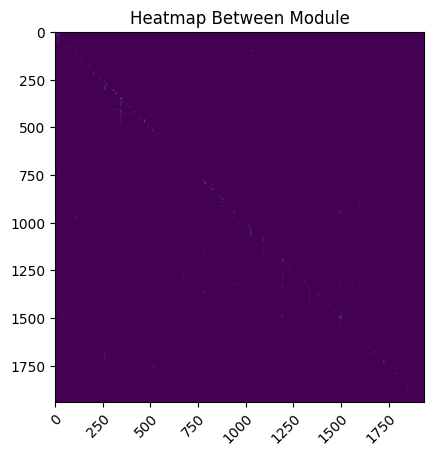

In [557]:
fig, ax = plt.subplots()
im = ax.imshow(data)

# Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(list(listLabel))), labels=list(listLabel))
# ax.set_yticks(np.arange(len(list(listLabel))), labels=list(listLabel))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Heatmap Between Module")

# plt.figure(figsize=(20,6))
plt.show()

In [626]:
def simName(cN1,cN2):
    arr1 = (cN1.split("."))[ : -1]
    arr2 = (cN2.split("."))[ : -1]
    sameRoot = 0
    totalRoot = max(len(arr1),len(arr2))
    for idx in range(0,len(arr1)):
        if idx >= len(arr2):
            return sameRoot/totalRoot
        if arr1[idx] == arr2[idx]:
            sameRoot += 1
        else:
            return sameRoot/totalRoot
    return sameRoot/totalRoot

In [627]:

distanceMatrix = [[0.00 for i in range(data.shape[1])] for j in range(data.shape[0])]

np.fill_diagonal(data,1) 
for i in range(0,len(data)):
    for j in range(0,i):
        distanceStructual = round(1- simStr(data[i, :], data[j, :], i, j,sum(data[:, i]), sum(data[:, j])),2)
        distanceJaccard = round(1- simJaccard(data[i, :] , data[j,:]),2)
        distanceModul = simName(listLabel[i],listLabel[j])
        distanceMatrix[i][j] = ((distanceStructual + distanceJaccard + distanceModul ) / 3)
        distanceMatrix[j][i] = distanceMatrix[i][j]

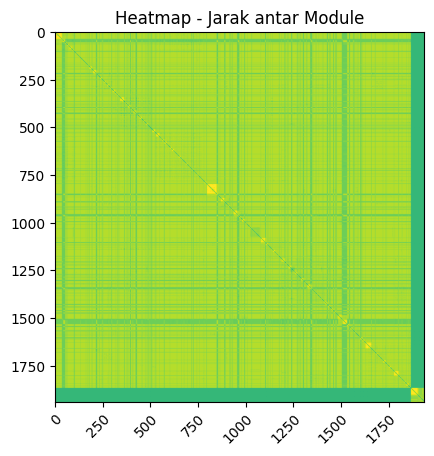

<Figure size 2000x600 with 0 Axes>

In [599]:
# Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()
im = ax.imshow(distanceMatrix)

# Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(list(listLabel))), labels=list(listLabel))
# ax.set_yticks(np.arange(len(list(listLabel))), labels=list(listLabel))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Heatmap - Jarak antar Module")

plt.figure(figsize=(20,6))
plt.show()

#### Clustering

In [560]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import cophenet,linkage

In [628]:
def calculateCluster(y,_method):
    z  =  linkage(y, method=_method,optimal_ordering=True)
    plt.figure(figsize=(250,8))
    sch.dendrogram(z,labels=listLabel)
    plt.title(f'Dendrogram {_method} Linkage')
    plt.xlabel('Module')
    plt.ylabel('Distances')
    plt.show()    
    return z

In [600]:
cDM = squareform(distanceMatrix,checks=True)

In [563]:
from scipy.spatial.distance import pdist
def evaluePDist(z):
    c, _ = cophenet(z, cDM)
    print("Cophenet  Val:",c)

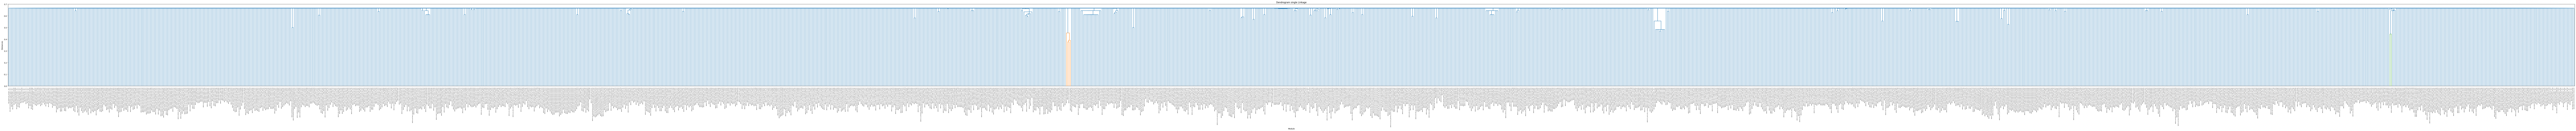

Cophenet  Val: 0.02733877768711974


In [629]:
zSingle = calculateCluster(cDM,"single")
evaluePDist(zSingle)

In [630]:
zComplete = calculateCluster(cDM,"complete")
evaluePDist(zComplete)

Cophenet  Val: 0.04140005016205623


In [631]:
zAverage = calculateCluster(cDM,"average")
evaluePDist(zAverage)

Cophenet  Val: 0.3294960423397764


#### Pemilihan Cluster 

In [567]:
from scipy.cluster.hierarchy import cut_tree

In [568]:
def cutTreeToCluster(ct):
    c = {}
    for i, x in enumerate(ct):
        if x[0] not in c:
            c[x[0]] = []
        c[x[0]].append(listLabel[i])
    return c        

Based on Structural and Behavioral Dependencies:

In [569]:
def mergeClass(c):
    mergeCall = {}
    innerCallClass = {}
    dictKey = {}
    
    for _ , v in c.items():
        i = v[0]
        mergeCall[i] = {}
        innerCallClass[i] = {}
        
        for c in range(0,len(v)):
            innerCallClass[i][v[c]] = {}
            for k, call in callGraphFinal[v[c]].items():
                if k in v:
                    if k not in innerCallClass[i][v[c]]:
                        innerCallClass[i][v[c]][k] = 0
                    innerCallClass[i][v[c]][k] += call
                    continue
                if k not in mergeCall[i]:
                    mergeCall[i][k] = 0
                mergeCall[i][k] += call
                dictKey[k] = i
    
    for k, p in mergeCall.items():
        newMergeCall = {}
        for  call, val in p.items():
            if call not in mergeCall:
                if dictKey[call] not in  newMergeCall:
                    newMergeCall[dictKey[call]] = 0
                newMergeCall[dictKey[call]] +=  val
            else:
                newMergeCall[call] = val
        mergeCall[k] = newMergeCall
    return mergeCall , innerCallClass

In [570]:
def NbCalls(m,c1,c2):
    return m[c2][c1]

In [571]:
def CoupP(m, c1,c2):
    TotalNBCalls = 0
    for x in range(0,len(m)):
        if m[c1][x] > 0:
            TotalNBCalls += m[c1][x]
        if m[c2][x] > 0:
            TotalNBCalls += m[c2][x]
    if TotalNBCalls == 0:
        # print("NB Calls 0")
        return 0
    return (NbCalls(m,c1,c2) + NbCalls(m,c2,c1))/TotalNBCalls

In [572]:
def InterCoup(m):
    sumCoup = 0
    NbPossiblePairs = len(m)
    for c1 in range(0,len(m)):
        for c2 in range(0,len(m)):
          sumCoup += CoupP(m,c1,c2)
    return sumCoup/NbPossiblePairs

In [573]:
def InterCoh(m, rm):
    NbDirectConnections = 0
    NbPossibleConnection = 0
    for _, p in rm.items():
        if len(p) == 0:
            continue
        adj , _ = createAdjacentMatrix(p)
        for c1 in range(0,len(adj)):
            for c2 in range(0,len(adj)):
                NbDirectConnections += CoupP(adj,c1,c2)
    for c1 in range(0,len(m)):
        for c2 in range(0,len(m)):
            NbPossibleConnection += CoupP(m,c1,c2)
    NbPossibleConnection +=  NbDirectConnections 
    return NbDirectConnections / NbPossibleConnection    
    

In [574]:
from scipy import stats as st
def modusSizeService(rm):
    sizeP = []
    for p in rm:
        sizeP.append(len(rm[p]))
    abc = np.array(sizeP)
    return (st.mode(abc,keepdims=False)).mode
    

In [575]:
def FOne(m,rm):
    interCoup = InterCoup(m)
    interCoh = InterCoh(m,rm)
    modus = modusSizeService(rm)
    value = (0.5*(interCoh*len(m) + (1-interCoup*len(m))))+(0.5 * modus * interCoup)
    return {
            "coupling": round(interCoup,6),
            "cohesion": round(interCoh,6),
            "value": round(value, 4),
            "clusterSize": len(m)
    }

In [576]:
from multiprocessing import Process, Manager

In [577]:
def calculate_FOne(z, _n_clusters):
    ct = cut_tree(z, n_clusters=_n_clusters)
    clusterCT = cutTreeToCluster(ct)
    mgCls, inCls = mergeClass(clusterCT)
    adjMerge, _ =  createAdjacentMatrix(mgCls)
    result = FOne(adjMerge,inCls)
    print(result)
    return result

In [614]:
ct = cut_tree(zAverage, n_clusters=20)
clusterCT = cutTreeToCluster(ct)
mgCls, inCls = mergeClass(clusterCT)

In [615]:
clusterCT

{0: ['addons.account.demo.account_demo',
  'addons.account.models.account_account',
  'addons.account.models.account_account_tag',
  'addons.account.models.account_analytic_account',
  'addons.account.models.account_analytic_distribution_model',
  'addons.account.models.account_analytic_line',
  'addons.account.models.account_analytic_plan',
  'addons.account.models.account_bank_statement',
  'addons.account.models.account_bank_statement_line',
  'addons.account.models.account_cash_rounding',
  'addons.account.models.account_full_reconcile',
  'addons.account.models.account_incoterms',
  'addons.account.models.account_journal',
  'addons.account.models.account_journal_dashboard',
  'addons.account.models.account_move',
  'addons.account.models.account_move_line',
  'addons.account.models.account_move_line_tax_details',
  'addons.account.models.account_partial_reconcile',
  'addons.account.models.account_payment',
  'addons.account.models.account_payment_method',
  'addons.account.model

In [617]:
inCls

{'addons.account.demo.account_demo': {'addons.account.demo.account_demo': {'addons.account.models.chart_template': 1},
  'addons.account.models.account_account': {'odoo.addons.base.models.res_company': 1},
  'addons.account.models.account_account_tag': {'odoo.addons.base.models.res_country': 1,
   'odoo.addons.base.models.res_users': 2},
  'addons.account.models.account_analytic_account': {'addons.analytic.models.analytic_account': 1},
  'addons.account.models.account_analytic_distribution_model': {'addons.analytic.models.analytic_distribution_model': 1,
   'addons.product.models.product_category': 1,
   'addons.product.models.product_product': 1},
  'addons.account.models.account_analytic_line': {'addons.analytic.models.analytic_line': 1,
   'addons.account.models.account_account': 1,
   'addons.account.models.account_move_line': 1,
   'addons.product.models.product_product': 1},
  'addons.account.models.account_analytic_plan': {'addons.analytic.models.analytic_plan': 1,
   'addons.pr

In [616]:
mgCls

{'addons.account.demo.account_demo': {'addons.mail.models.mail_render_mixin': 7,
  'addons.mail.models.template_reset_mixin': 3,
  'addons.mail.models.update': 1},
 'addons.im_livechat.models.res_users_settings': {'addons.website.models.website_rewrite': 7,
  'addons.im_livechat.models.res_users_settings': 2},
 'addons.mail.models.ir_action_act_window': {'addons.mail.models.ir_action_act_window': 1},
 'addons.mail.models.ir_attachment': {'addons.mail.models.ir_attachment': 1},
 'addons.mail.models.ir_config_parameter': {'addons.mail.models.ir_config_parameter': 1},
 'addons.mail.models.ir_http': {'addons.mail.models.ir_http': 1},
 'addons.mail.models.ir_model': {'addons.mail.models.models': 1},
 'addons.mail.models.ir_model_fields': {'addons.mail.models.models': 1},
 'addons.mail.models.ir_ui_view': {'addons.mail.models.ir_ui_view': 1},
 'addons.mail.models.mail_gateway_allowed': {'addons.website.models.website_rewrite': 2},
 'addons.mail.models.mail_ice_server': {'addons.website.model

In [580]:
print(calculate_FOne(zSingle, 30))

KeyboardInterrupt: 

In [ ]:
def analystCluster(z):
    manager = Manager()
    dResult = manager.dict()
    MAX_PROCESSING = 4

    def target_Process(_n_clusters):
        try :
            dResult[_n_clusters] = calculate_FOne(z, _n_clusters)
        except Exception as e:
            print("Cluster: " ,_n_clusters , " E: "  ,  e)
    
    for b in range(1,len(listLabel), MAX_PROCESSING*10):
        t = b
        procs = []
        
        while t < b+MAX_PROCESSING*10 and t <= len(listLabel):
            proc = Process(target=target_Process, args=(t,))
            procs.append(proc)
            proc.start()
            t+=10
        for proc in procs:
            proc.join()
    
    qualityCluster = []
    for r in  sorted(dResult):
        qualityCluster.append(dResult[r])
    return qualityCluster

In [ ]:
qcSingle = analystCluster(zSingle)

KeyboardInterrupt: 

In [604]:
qcComplete = analystCluster(zComplete)

{'coupling': 1.094677, 'cohesion': 0.894247, 'value': 14.9082, 'clusterSize': 31}
{'coupling': 1.12213, 'cohesion': 0.962374, 'value': 16.7766, 'clusterSize': 21}
{'coupling': 1.108114, 'cohesion': 0.986498, 'value': 34.7367, 'clusterSize': 11}


KeyboardInterrupt: 

In [ ]:
qcAverage = analystCluster(zAverage)

In [ ]:
import matplotlib.pyplot as plt
def visualizeQualityCluster(qualityCluster,linkageType):
    def getAsListResult(qualityCluster):
        clusterSizeIter = []
        couplingIter = []
        cohesionIter =[]
        for v in qualityCluster:
            clusterSizeIter.append( v['clusterSize'])
            couplingIter.append( v['coupling'])
            cohesionIter.append( v['cohesion'])
        return clusterSizeIter, couplingIter, cohesionIter
    clusterSizeIter, couplingIter, cohesionIter  = getAsListResult(qualityCluster) 

    plt.plot(clusterSizeIter, couplingIter , label ='Coupling')
    plt.plot(clusterSizeIter, cohesionIter  , label ='Cohesion')

    plt.xlabel("Jumlah Partisi/Cluster")
    plt.ylabel("Coupling x Cohesion")
    plt.legend()
    plt.title(f'Perbandingan Coupling & Cohesion dengan Jumlah Cluster ({linkageType})')
    plt.show()


In [ ]:
visualizeQualityCluster(qcSingle,"Single Linkage")

In [ ]:
visualizeQualityCluster(qcComplete,"Complete Linkage")

In [ ]:
visualizeQualityCluster(qcAverage,"Average Linkage")

#### Pemilihan Jumlah Cluster terbaik  ????

In [ ]:
maxVal = {'value':None , 'clusterSize' : len(listLabel)}
for c in qcSingle:
    if maxVal['value'] == None:
        maxVal = c
    if c['value'] >= maxVal['value']  :
        maxVal = c
print(f'Jumlah Cluster terbaik: {maxVal["clusterSize"]} service/partisi \nDetail:',  maxVal)

Pembagian service dengan modules-nya

In [ ]:
#32
ct = cut_tree(zAverage, n_clusters=256)
clusterCT = cutTreeToCluster(ct)
mgCls, inCls = mergeClass(clusterCT)

In [ ]:
callGraphFinal['addons.pos_stripe']

In [ ]:
clusterCT